In [1]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
#import imageio
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

2023-06-30 17:21:59.908228: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
#
# reading data
#
path = '/N/u/ckieu/Carbonate/model/deep-learning/Unet'
image_path = os.path.join(path, './data/images/')
mask_path = os.path.join(path, './data/target/')
image_list_orig = os.listdir(image_path)
image_list = [image_path+i for i in image_list_orig]
temp_list = [mask_path+i for i in image_list_orig]
mask_list = [sub.replace('.jpg', '.png') for sub in temp_list]
print('image_list_orig',image_list_orig[-2:])
print('image_list',image_list[-2:])
print('mask_list',mask_list[-2:])

image_list_orig ['havanese_128.jpg', 'english_setter_22.jpg']
image_list ['/N/u/ckieu/Carbonate/model/deep-learning/Unet/./data/images/havanese_128.jpg', '/N/u/ckieu/Carbonate/model/deep-learning/Unet/./data/images/english_setter_22.jpg']
mask_list ['/N/u/ckieu/Carbonate/model/deep-learning/Unet/./data/target/havanese_128.png', '/N/u/ckieu/Carbonate/model/deep-learning/Unet/./data/target/english_setter_22.png']


[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
(500, 370, 3) (500, 370)


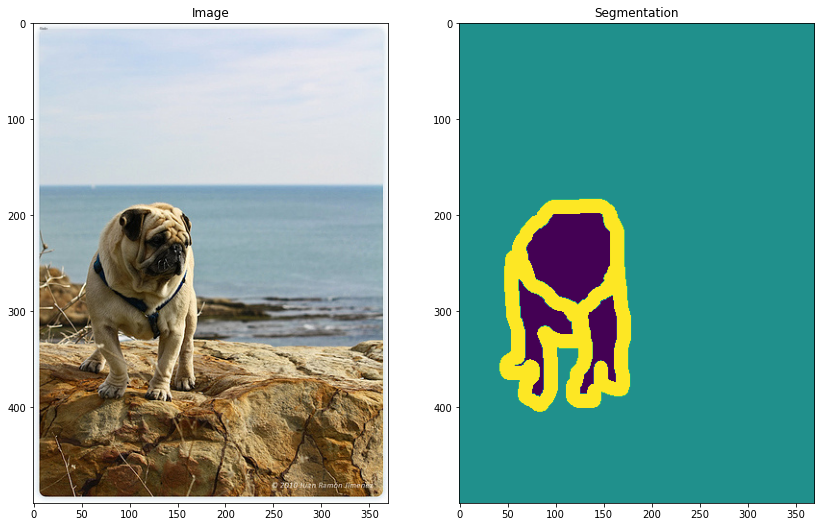

In [3]:
#
# plot a few sample
#
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :])
arr[1].set_title('Segmentation')
print(mask[250,:])
print(img.shape,mask.shape)

In [28]:
#
# bundle the image and target into a single TF dataset type
#
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))
for image, mask in dataset.take(3):
    print(image)
    print(mask)
print(len(list(dataset)),dataset.cardinality().numpy())    

tf.Tensor(b'/N/u/ckieu/Carbonate/model/deep-learning/Unet/./data/images/miniature_pinscher_85.jpg', shape=(), dtype=string)
tf.Tensor(b'/N/u/ckieu/Carbonate/model/deep-learning/Unet/./data/target/miniature_pinscher_85.png', shape=(), dtype=string)
tf.Tensor(b'/N/u/ckieu/Carbonate/model/deep-learning/Unet/./data/images/boxer_98.jpg', shape=(), dtype=string)
tf.Tensor(b'/N/u/ckieu/Carbonate/model/deep-learning/Unet/./data/target/boxer_98.png', shape=(), dtype=string)
tf.Tensor(b'/N/u/ckieu/Carbonate/model/deep-learning/Unet/./data/images/pug_9.jpg', shape=(), dtype=string)
tf.Tensor(b'/N/u/ckieu/Carbonate/model/deep-learning/Unet/./data/target/pug_9.png', shape=(), dtype=string)


2023-06-30 17:55:40.691778: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


7390 7390


In [37]:
#
# preprocess the data and normalize such that the data values are now betwee  [0,1]
#
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (128, 128), method='nearest')
    input_mask = tf.image.resize(mask, (128, 128), method='nearest')
    print(image.shape,input_image.shape)
    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)
#print(len(list(processed_image_ds))) 

(None, None, 3) (128, 128, 3)


In [6]:
#
# Define U-Net encoder block, which consists of 2 Conv and output next_layer + skip block
#
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters, # Number of filters
                  3,         # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,         # Kernel size
                  activation='relu',
                  padding='same',
                  # set 'kernel_initializer' same as above
                  kernel_initializer='he_normal')(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)     
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(2,strides=2)(conv) 
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [7]:
#
# Define U-Net decoder block
#
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,            # Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,            # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                  # set 'kernel_initializer' same as above
                 kernel_initializer='he_normal')(conv)
    
    return conv

In [8]:
#
# define U-Net model finally
#
def unet_model(input_size=(64, 64, 3), n_filters=32, n_classes=3):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8, dropout_prob=0.3) 
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16, dropout_prob=0.3, max_pooling=False) 
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0],cblock4[1], n_filters=n_filters*8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6,cblock3[1], n_filters=n_filters*4)
    ublock8 = upsampling_block(ublock7,cblock2[1], n_filters=n_filters*2)
    ublock9 = upsampling_block(ublock8,cblock1[1], n_filters=n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 # set 'kernel_initializer' same as above exercises
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter as output, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [10]:
#
# Call UNet model now
#
img_height = 128
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

                                )                                                                 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 3)  99          ['conv2d_18[0][0]']              
                                                                                                  
Total params: 8,639,811
Trainable params: 8,639,811
Non-trainable params: 0
__________________________________________________________________________________________________


In [11]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

7390
(500, 333, 3) (500, 333, 1)


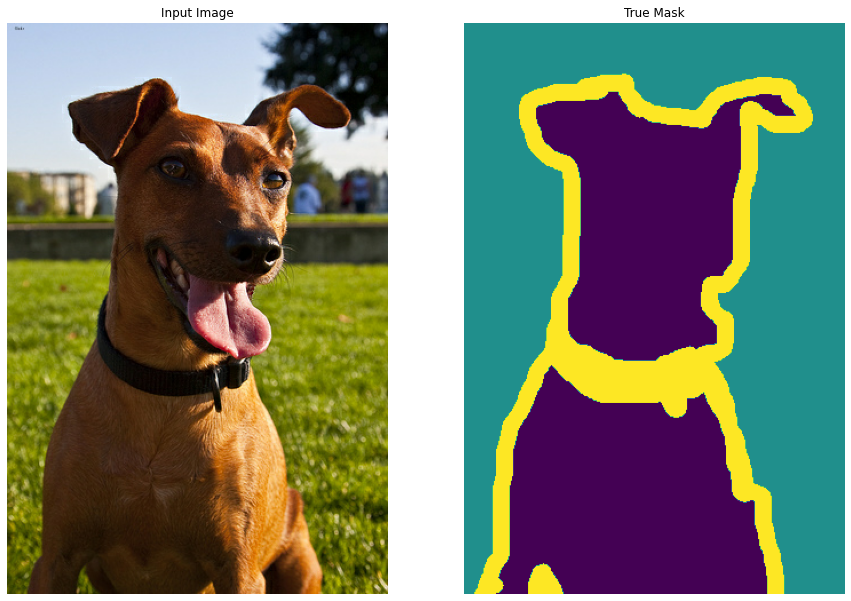

(128, 128, 3) (128, 128, 1)


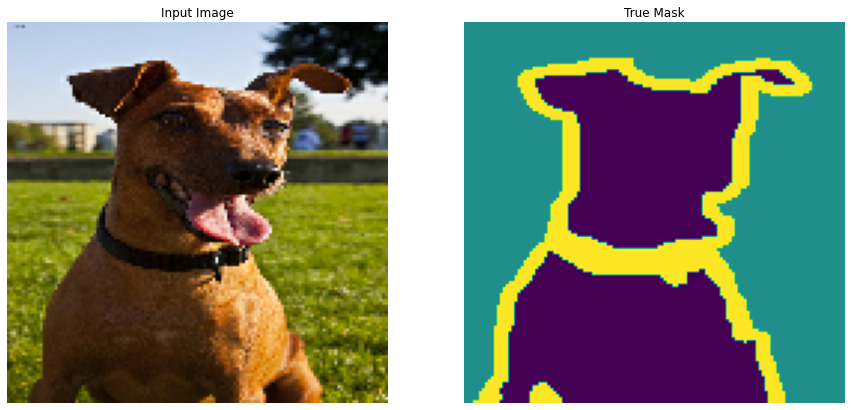

In [38]:
print(processed_image_ds.cardinality().numpy())
for image, mask in image_ds.take(1):    
    sample_image, sample_mask = image, mask
    print(image.shape,mask.shape)
display([sample_image, sample_mask])

for image, mask in processed_image_ds.take(1):    
    sample_image, sample_mask = image, mask
    print(image.shape,mask.shape)
display([sample_image, sample_mask])
    

In [39]:
#
# train Unet model now
#
EPOCHS = 5
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/5


2023-06-30 18:21:37.676102: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


ValueError: Creating variables on a non-first call to a function decorated with tf.function.